# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [5]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [6]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [7]:
import os
from torchvision.datasets.utils import download_url

In [8]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [9]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets/lung_field_dataset.npz


In [11]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [12]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

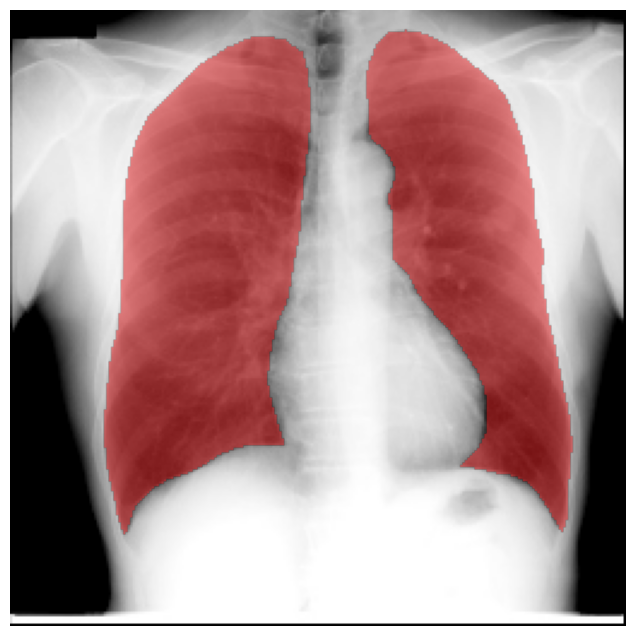

In [13]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# Helper function to convert data to SAM format
def prepare_data_for_sam(x, y):
    # Map to [0, 255] and uint8
    x = map_interval(x, np.min(x), np.max(x), 0, 255).astype(np.uint8)
    y = y.astype(np.uint8)
    
    # Remove channel dim if present
    if x.ndim == 4: x = x.squeeze(-1)
    if y.ndim == 4: y = y.squeeze(-1)

    # Stack to make RGB (N, H, W, 3)
    x = np.stack((x,)*3, axis=-1)
    return x, y

x_train, y_train = prepare_data_for_sam(x_train, y_train)
x_val, y_val = prepare_data_for_sam(x_val, y_val)
x_test, y_test = prepare_data_for_sam(x_test, y_test)

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [14]:
example_img, example_mask = x_train[0], y_train[0]

# --- Define Helper to Calculate Box from Mask ---
def get_bbox_from_mask(mask):
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0: return np.array([0, 0, 1, 1]) # Safety for empty masks
    
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    
    # Add padding
    padding = 5
    H, W = mask.shape
    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(W, x_max + padding)
    y_max = min(H, y_max + padding)
    
    return np.array([x_min, y_min, x_max, y_max])

# Calculate the box for this example
input_box = get_bbox_from_mask(example_mask)
input_points = None 
input_label = None 

print(f"Calculated BBox: {input_box}")

Calculated BBox: [ 34   3 238 222]


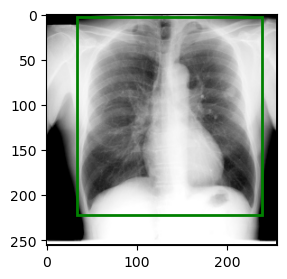

In [15]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_box(input_box, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [16]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    box=input_box[None, :],   # Pass the box (SAM expects shape 1x4)
    multimask_output=False,   # With box, False is usually better (returns 1 best mask)
)

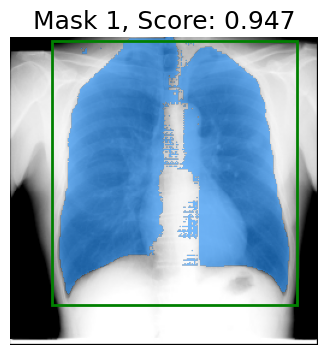

In [17]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_box(input_box, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [20]:
import torchmetrics
from scipy.ndimage import label  

f1 = torchmetrics.F1Score(task="binary")
f1_scores = []

print("Running evaluation with Split-Box strategy (Left & Right Lung separately)...")

for img, mask_gt in zip(x_val, y_val):
    # 1. Skip empty masks
    if np.sum(mask_gt) == 0:
        continue

    # 2. Find connected components using SCIPY instead of CV2. This identifies the separate lung lobes (labels 1, 2, etc.)
    labels_im, num_labels = label(mask_gt)
    
    # Accumulate predictions for this single image
    combined_prediction = np.zeros(mask_gt.shape, dtype=bool)
    
    # 3. Loop over each lung object found
    for i in range(1, num_labels + 1):
        # Create a mini-mask for just this one lung
        single_lung_mask = (labels_im == i).astype(np.uint8)
        
        # Get box for this specific lung
        box_prompt = get_bbox_from_mask(single_lung_mask)
        
        # Predict just this lung
        predictor.set_image(img)
        masks, scores, logits = predictor.predict(
            box=box_prompt[None, :], 
            multimask_output=False
        )
        
        # Add to our final image prediction
        combined_prediction = np.logical_or(combined_prediction, masks[0])
    
    # 4. Calculate Score
    preds = torch.tensor(combined_prediction, dtype=torch.int)
    target = torch.tensor(mask_gt > 0, dtype=torch.int)
    
    f1_scores.append(f1(preds, target).item())
    f1.reset()

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Running evaluation with Split-Box strategy (Left & Right Lung separately)...
Mean F1 score: 0.9141
Standard deviation: 0.0299


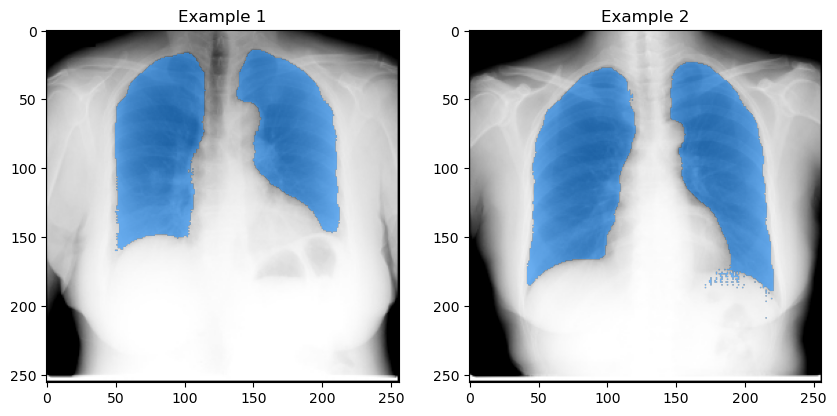

In [22]:
# Quick block to visualize the first 2 images for Section 2.2 analysis
count = 0
plt.figure(figsize=(10, 5))

for img, mask_gt in zip(x_val, y_val):
    if count >= 2: break # Stop after 2 images
    if np.sum(mask_gt) == 0: continue

    # 1. Set image once per image (not once per lung)
    predictor.set_image(img) 

    # Run your Split-Box Logic
    labels_im, num_labels = label(mask_gt)
    combined_prediction = np.zeros(mask_gt.shape, dtype=bool)
    
    for i in range(1, num_labels + 1):
        single_lung_mask = (labels_im == i).astype(np.uint8)
        box_prompt = get_bbox_from_mask(single_lung_mask)
        
        # 2. Just predict here (FAST)
        masks, _, _ = predictor.predict(box=box_prompt[None, :], multimask_output=False)
        combined_prediction = np.logical_or(combined_prediction, masks[0])

    # Plot
    plt.subplot(1, 2, count + 1)
    plt.imshow(img)
    show_mask(combined_prediction, plt.gca()) 
    plt.title(f"Example {count + 1}")
    count += 1

plt.show()